In [1]:
import json
import pathlib

import matplotlib.ticker
import matplotlib.pylab as plt
import pandas as pd

from hubbardml import keys
from hubbardml import plots

import olivines

In [31]:
EXPERIMENT_DIR = pathlib.Path(
    "outputs/train.batch_size=16,train.max_epochs=4000/2023-07-28_10-29-53"
)
# EXPERIMENT_DIR = pathlib.Path(
#     "outputs/train.batch_size=32,train.max_epochs=4000/2023-07-27_14-28-01"
# )
EXPERIMENT_DIR = pathlib.Path(
    "outputs/train.batch_size=16,train.max_epochs=10000/2023-07-28_15-29-57"
)
DATASET = "dataset.json"
RESULTS_FILE = "hubbard_u_olivines.json"

In [32]:
uv_data = pd.read_json(EXPERIMENT_DIR / DATASET)
labels = {
    'LiFePO4': 'Li$_{x}$FePO$_4$',
    'LiMnPO4': 'Li$_{x}$MnPO$_4$',
}
uv_data

,dir,material,is_vdw,uv_iter,formula,cell,n_atoms_uc,person,structure_index,pw_time_unix,...,atom_2_occs_2,atom_2_frac_coords,atom_2_starting_mag,atom_2_final_mag,param_delta,species,label,colour,sc_paths,occupation
34927,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFeP...,C1_Li0.00FePO4,False,1,,"[18.7209065005, 0.0, 0.0, 0.0, 10.995085972, 0...",24,iurii,71,1624062645,...,"[[0.148, -0.015, 0.0, 0.007, 0.0], [-0.015, 0....","[-0.0081634, 0.0, -0.012175199999999999]",0,3.6720,6.0307,[Fe],Fe,#E06633,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFeP...,0.0
35012,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFeP...,C1_Li0.00FePO4,False,1,,"[18.7209065005, 0.0, 0.0, 0.0, 10.995085972, 0...",24,iurii,71,1624062645,...,"[[0.148, 0.015, 0.0, 0.007, 0.0], [0.015, 0.21...","[0.4918356, 0.0, -0.43224209999999996]",0,3.6720,6.0307,[Fe],Fe,#E06633,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFeP...,0.0
35112,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFeP...,C1_Li0.00FePO4,False,1,,"[18.7209065005, 0.0, 0.0, 0.0, 10.995085972, 0...",24,iurii,71,1624062645,...,"[[0.996, -0.001, 0.0, -0.001, 0.0], [-0.001, 0...","[-0.0561447, 0.5, -0.5121745]",0,-3.6719,6.0307,[Fe],Fe,#E06633,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFeP...,0.0
35212,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFeP...,C1_Li0.00FePO4,False,1,,"[18.7209065005, 0.0, 0.0, 0.0, 10.995085972, 0...",24,iurii,71,1624062645,...,"[[0.996, 0.001, 0.0, -0.001, 0.0], [0.001, 0.9...","[0.44385529999999995, 0.5, -0.932241]",0,-3.6719,6.0307,[Fe],Fe,#E06633,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFeP...,0.0
35605,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFeP...,C1_Li0.00FePO4,False,2,,"[18.699972807, 0.0, 1.95095e-05, 0.0, 11.00923...",24,iurii,72,1624360808,...,"[[0.10300000000000001, -0.017, 0.0, 0.002, 0.0...","[-0.0078531, 0.0, -0.0135788]",0,3.8790,-0.6279,[Fe],Fe,#E06633,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFeP...,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65276,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,B5_Li1.00MnPO4,False,3,,"[19.7940850765, 0.0, 0.0, 0.0, 11.511736551, 0...",28,iurii,111,1594749234,...,"[[0.996, -0.001, 0.0, -0.001, 0.0], [-0.001, 0...","[0.4372178, 0.5, -0.9466146]",0,-4.2040,0.1188,[Mn],Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,1.0
65669,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,B5_Li1.00MnPO4,False,4,,"[19.7940850765, 0.0, 0.0, 0.0, 11.511736551, 0...",28,iurii,112,1595848609,...,"[[0.02, 0.002, 0.0, 0.006, 0.0], [0.002, 0.057...","[-0.001527, 0.0, 0.0021371999999999997]",0,4.2058,-0.0129,[Mn],Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,1.0
65754,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,B5_Li1.00MnPO4,False,4,,"[19.7940850765, 0.0, 0.0, 0.0, 11.511736551, 0...",28,iurii,112,1595848609,...,"[[0.02, -0.002, 0.0, 0.006, 0.0], [-0.002, 0.0...","[0.4984724, 0.0, -0.4466148]",0,4.2058,-0.0129,[Mn],Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,1.0
65854,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,B5_Li1.00MnPO4,False,4,,"[19.7940850765, 0.0, 0.0, 0.0, 11.511736551, 0...",28,iurii,112,1595848609,...,"[[0.996, 0.001, 0.0, -0.001, 0.0], [0.001, 0.9...","[-0.06278249999999999, 0.5, -0.4978627]",0,-4.2058,-0.0129,[Mn],Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,1.0


In [33]:
uv_data[uv_data[keys.PARAM_TYPE] == keys.PARAM_V].groupby(keys.MATERIAL).value_counts([olivines.Keys.OCCUPATION])

Series([], dtype: int64)

In [34]:
sum(uv_data[keys.PARAM_OUT] < 0.25)

0

In [35]:
def create_plots(df: pd.DataFrame, logy=False, scale=1.0):
    comparison_plots = {}

    if olivines.Keys.TRAIN_RMSE in df:
        cols = [olivines.Keys.TRAIN_RMSE, olivines.Keys.MODEL_RMSE]
        series_labels = 'ML (train)', 'ML (validate)'
    else:
        cols = [olivines.Keys.MODEL_RMSE]
        series_labels = ('ML (validate)',)

    for material in df[olivines.Keys.MATERIAL].unique():
        frame = df[df[olivines.Keys.MATERIAL] == material]
        ref_rmse = frame.iloc[0][olivines.Keys.REF_RMSE]  # They are all the same

        grouped = frame.groupby(olivines.Keys.NUM_OCCUPATIONS)[cols]
        mins = grouped.min()
        maxs = grouped.max()
        means = grouped.mean()

        errors = [[means[c] - mins[c], maxs[c] - means[c]] for c in cols]

        fig = plt.figure(figsize=(6 * scale, 4 * scale))
        ax = fig.gca()

        ax = means.plot(
            ax=ax,
            # colormap=plots.colourmap,
            color=plots.train_validate_colours.values(),
            yerr=errors,
            fmt='o--',
            logy=logy,
            solid_capstyle='projecting',
            capsize=5,
            capthick=2,
            title=labels[material],
            # linewidth=3,
            # alpha=0.5,
            ylabel='RMSE (eV)',
            xlabel='Num. training occupations',
        );

        # Plot the baseline RMSE
        ax.plot(
            [df[olivines.Keys.NUM_OCCUPATIONS].min(),
             df[olivines.Keys.NUM_OCCUPATIONS].max()],
            [ref_rmse, ref_rmse],
        )

        ax.legend((f"Ref {ref_rmse * 1000:.0f} meV (50%)",) + series_labels)
        ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
        ax.set_ylim([0, 0.9])

        comparison_plots[material] = ax

    return comparison_plots

# Olivines analysis

In [36]:
results_file = EXPERIMENT_DIR / RESULTS_FILE
with open(results_file, 'r') as file:
    hubbard_u_olivines = pd.DataFrame(json.load(file))
hubbard_u_olivines;

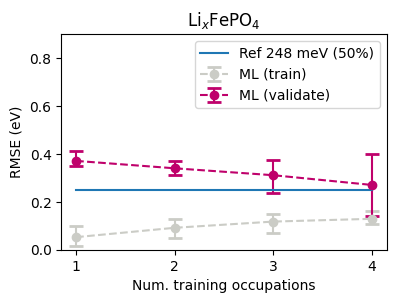

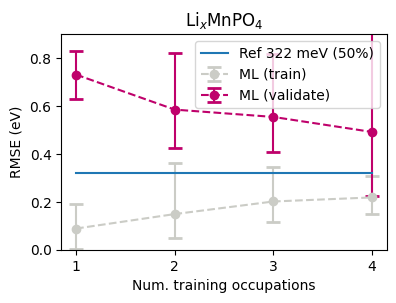

In [37]:
for material, ax in create_plots(hubbard_u_olivines, scale=0.7).items():
    ax.get_figure().savefig(f'plots/{material}_U_occs_comparison.pdf', bbox_inches='tight')

In [38]:
results_file = 'hubbard_v_olivines.json'
with open(results_file, 'r') as file:
    hubbard_v_olivines = pd.DataFrame(json.load(file))

for material, ax in create_plots(hubbard_v_olivines, logy=True, scale=0.7).items():
    ax.get_figure().savefig(f'plots/{material}_V_occs_comparison.pdf', bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: 'hubbard_v_olivines.json'

In [ ]:
uv_data